In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import datetime
from sklearn.metrics import fbeta_score,roc_auc_score
from mochi import f_beta_01,runLGBM

In [2]:
from sklearn.ensemble import RandomForestClassifier as RFC #sklearn 0.19

In [3]:
class Config:
    pass
config = pd.read_pickle('config.pkl')
data_path = config.data_path
feature_path = config.feature_path
#print(dir(config))
print('Currently has feature-sets')
print(config.feature_dict.keys())

Currently has feature-sets
dict_keys(['trade_and_recent_login_comparing', 'recent_login_detail', 'trade_detail_feature', 'login_trade_hist_stats', 'llc_user_habbit', 'hcc_user_habbit', 'hcc_properties', 'hcc_target_encoding', 'login_detail_new_features', 'hcc_mult_target_encoding', 'hcc_user_trade_habbit', 'hcc_trade_properties'])


In [11]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats']+
              config.feature_dict['llc_user_habbit']+
             config.feature_dict['hcc_user_habbit']+
              config.feature_dict['hcc_properties']+
            config.feature_dict['hcc_target_encoding']+
                    config.feature_dict['login_detail_new_features']+
              config.feature_dict['hcc_trade_properties']+
              config.feature_dict['hcc_mult_target_encoding']+
              config.feature_dict['hcc_user_trade_habbit']
             )
feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
    
trade_tt_mat = np.hstack(feature_sequence_list)
#trade_tt_mat[trade_tt_mat==-10]=np.nan

validation_tuple_list = config.single_module_validation_indice_set
train_labels = pd.read_pickle(data_path+'trade_train_label.pkl')

In [12]:
remaining_features = list(features)
result_list = []

while len(remaining_features) > 0.2*len(features):
    
    print('running with %d features' % len(remaining_features))
    result_unit_dict = {}
    
    #initiating the validation set
    remaining_features_ori_index = [features.index(x) for x in remaining_features]
    remainging_trade_tt_mat = trade_tt_mat[:,remaining_features_ori_index]
    
    #initialize the results
    feature_importance = np.zeros(len(remaining_features))
    fbetas = []
    auc_results = []
    
    feature_importance = np.zeros(len(remaining_features))
    
    for train_indice,val_indice in validation_tuple_list:
        
        watch_dict = {}
        #filter the validation values
        dev_X, val_X = remainging_trade_tt_mat[train_indice], remainging_trade_tt_mat[val_indice]
        dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values
    
        preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=remaining_features,verbose=None,eta=0.02,
                          early_stop=100,num_rounds=10000,watch_dict=watch_dict,feval = None)
        
        fbetas.append(fbeta_score(val_y, preds > 0.5, 0.1))
        auc_results.append(roc_auc_score(val_y,preds))
        
        feature_importance += model.feature_importance('gain')
        
        #preds = classifier.predict(val_X)
        print('turn passed')
        
    #appending the current result
    result_unit_dict['feature_count'] = len(remaining_features)
    result_unit_dict['used_features'] = remaining_features
    result_unit_dict['fbeta'] = np.mean(fbetas)
    result_unit_dict['auc'] = np.mean(auc_results)
    result_unit_dict['feature_count'] = len(remaining_features)
    result_unit_dict['used_features'] = remaining_features
    result_list.append(result_unit_dict)
    
    print('fbeta is %f'% result_unit_dict['fbeta'])
    print('auc is %f'% result_unit_dict['auc'])
    
    #choosing the remaining features
    sorted_feature_importacne = sorted(zip(remaining_features,feature_importance),key = lambda x : x[1],reverse = True)
    remaining_count = len(remaining_features)*0.95
    
    remaining_features = [x[0] for x in sorted_feature_importacne][:int(remaining_count)]


running with 446 features


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
fbeta is 0.899015
auc is 0.984971
running with 423 features
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
fbeta is 0.900354
auc is 0.984775
running with 401 features
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
fbeta is 0.894375
auc is 0.984605
running with 380 features
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
fbeta is 0.893531
auc is 0.984121
running with 361 features
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
fbeta is 0.891660
auc is 0.984915
running with 342 features
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
fbeta is 0.891138
auc is 0.984823
running with 324 features
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
fbeta is 0.896036
auc is 0.984931
running with 307 features
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
fbet

In [13]:
result_df = pd.DataFrame(result_list)

In [14]:
result_df

,auc,fbeta,feature_count,used_features
0,0.984971,0.899015,446,"[day, weekday, hour, day_cycle, weekday_cycle,..."
1,0.984775,0.900354,423,"[ip_t_encoding, id_t_encoding, city_id_t_encod..."
2,0.984605,0.894375,401,"[ip_t_encoding, id_t_encoding, city_id_t_encod..."
3,0.984121,0.893531,380,"[ip_t_encoding, id_t_encoding, city_id_t_encod..."
4,0.984915,0.891660,361,"[ip_t_encoding, id_t_encoding, city_id_t_encod..."
5,0.984823,0.891138,342,"[ip_t_encoding, id_t_encoding, city_id_t_encod..."
6,0.984931,0.896036,324,"[ip_t_encoding, id_t_encoding, city_id_t_encod..."
7,0.984788,0.891374,307,"[ip_t_encoding, id_t_encoding, city_id_t_encod..."
8,0.984792,0.887938,291,"[ip_t_encoding, id_t_encoding, ip_id_t_encodin..."
9,0.984589,0.898914,276,"[ip_t_encoding, id_t_encoding, city_id_t_encod..."


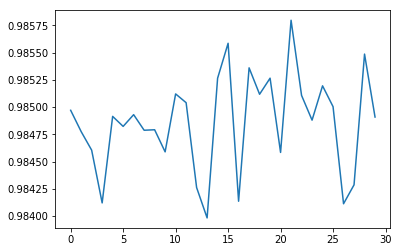

In [16]:
%matplotlib inline
plt.plot(result_df.index,result_df['auc'])

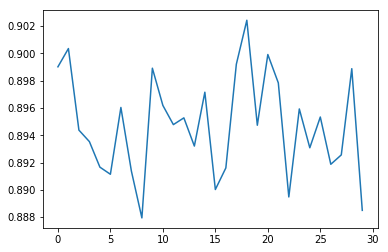

In [17]:
%matplotlib inline
plt.plot(result_df.index,result_df['fbeta'])

In [21]:
sorted(result_df.iloc[18]['used_features'])

['after_fail_max_15',
 'after_fail_max_30',
 'after_fail_max_360',
 'after_fail_min_3',
 'after_fail_min_360',
 'city_freq_rank_30',
 'city_freq_rank_360',
 'city_id_t_encoding',
 'city_max_min_dist_30',
 'city_max_min_dist_30_t_t',
 'city_max_min_dist_360',
 'city_max_min_dist_7',
 'city_most_freq_count_360',
 'city_most_freq_count_360_t_t',
 'city_most_freq_rate_30',
 'city_most_freq_rate_30_t_t',
 'city_most_freq_rate_360',
 'city_most_freq_rate_360_t_t',
 'city_most_freq_rate_7',
 'city_repeat_count_360',
 'city_repeat_count_360_t_t',
 'city_repeat_rate_360',
 'city_repeat_rate_360_t_t',
 'city_t_encoding',
 'city_used_count_30',
 'city_used_count_30_t_t',
 'city_used_count_360',
 'city_used_count_7',
 'day',
 'day_cycle_login_1',
 'day_cycle_login_2',
 'day_login_0',
 'day_login_1',
 'device_freq_rank_360',
 'device_freq_rank_360_t_t',
 'device_id_t_encoding',
 'device_most_freq_count_360',
 'device_most_freq_rate_30',
 'device_most_freq_rate_360',
 'device_most_freq_rate_360_t_t'

In [22]:
config = pd.read_pickle('config.pkl')
config.model_features['Lgbm_best_171'] = result_df.iloc[18]['used_features']

In [23]:
pd.to_pickle(config,'config.pkl')